# EXPLORATION 4. 거울아 거울아, 나는 멍멍이 상이니, 아니면 냥이 상이니?

---

#### import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

## Step 1. 데이터셋 내려받기

#### tf_flowers dataset

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

#### Scale and resize

In [3]:
IMG_SIZE = 160

In [4]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5)-1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

#### Check data

In [6]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

<Figure size 720x360 with 0 Axes>

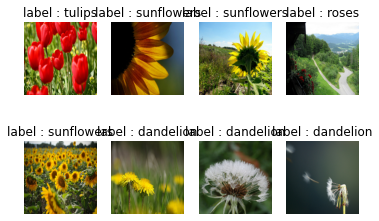

In [7]:
for idx, (image, label) in enumerate(train.take(8)):
    plt.subplot(2,4,idx+1)
    image = (image+1)/2
    plt.imshow(image)
    plt.title('label : {}'.format(get_label_name(label)))
    plt.axis('off')

## Step 3. 모델 설계하기

#### Base model

In [8]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [9]:
# # VGG16
# base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
#                                         include_top=False,
#                                         weights='imagenet')

# Xception
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')

In [10]:
base_model.trainable = False

#### Classifier

In [11]:
global_average_layer = GlobalAveragePooling2D()
dense_layer = Dense(512, activation='relu')
prediction_layer = Dense(5, activation='softmax')

#### Model

In [12]:
model = Sequential([
    base_model,
    global_average_layer,
    dense_layer,
#     Dropout(0.4),
    prediction_layer 
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 21,913,133
Trainable params: 1,051,653
Non-trainable params: 20,861,480
_________________________________________________________________


In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=RMSprop(lr=base_learning_rate),
             loss=sparse_categorical_crossentropy,
             metrics=['accuracy'])

## Step 4. 모델 학습시키기

#### Set batch

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 4000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

#### Train model

In [17]:
EPOCHS = 15
history = model.fit(train_batches,
                   epochs = EPOCHS,
                   validation_data = validation_batches)

Epoch 1/15
92/92 [==============================] - 50s 538ms/step - loss: 0.7017 - accuracy: 0.7534 - val_loss: 0.4633 - val_accuracy: 0.8529
Epoch 2/15
92/92 [==============================] - 6s 67ms/step - loss: 0.4206 - accuracy: 0.8515 - val_loss: 0.3988 - val_accuracy: 0.8692
Epoch 3/15
92/92 [==============================] - 6s 67ms/step - loss: 0.3351 - accuracy: 0.8907 - val_loss: 0.3816 - val_accuracy: 0.8774
Epoch 4/15
92/92 [==============================] - 6s 67ms/step - loss: 0.2813 - accuracy: 0.9094 - val_loss: 0.3436 - val_accuracy: 0.8774
Epoch 5/15
92/92 [==============================] - 6s 68ms/step - loss: 0.2402 - accuracy: 0.9332 - val_loss: 0.3342 - val_accuracy: 0.8828
Epoch 6/15
92/92 [==============================] - 6s 68ms/step - loss: 0.2098 - accuracy: 0.9421 - val_loss: 0.3254 - val_accuracy: 0.8692
Epoch 7/15
92/92 [==============================] - 6s 68ms/step - loss: 0.1800 - accuracy: 0.9510 - val_loss: 0.3190 - val_accuracy: 0.8801
Epoch 8/15


## Step 5. 모델 성능 평가하기

#### Train and validation graph

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

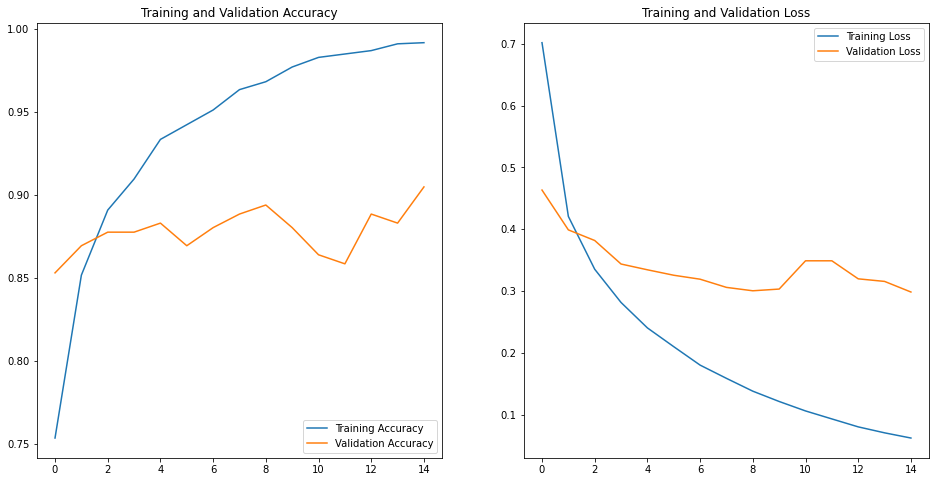

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Predict

In [20]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)

In [21]:
predictions = np.argmax(predictions, axis=1)

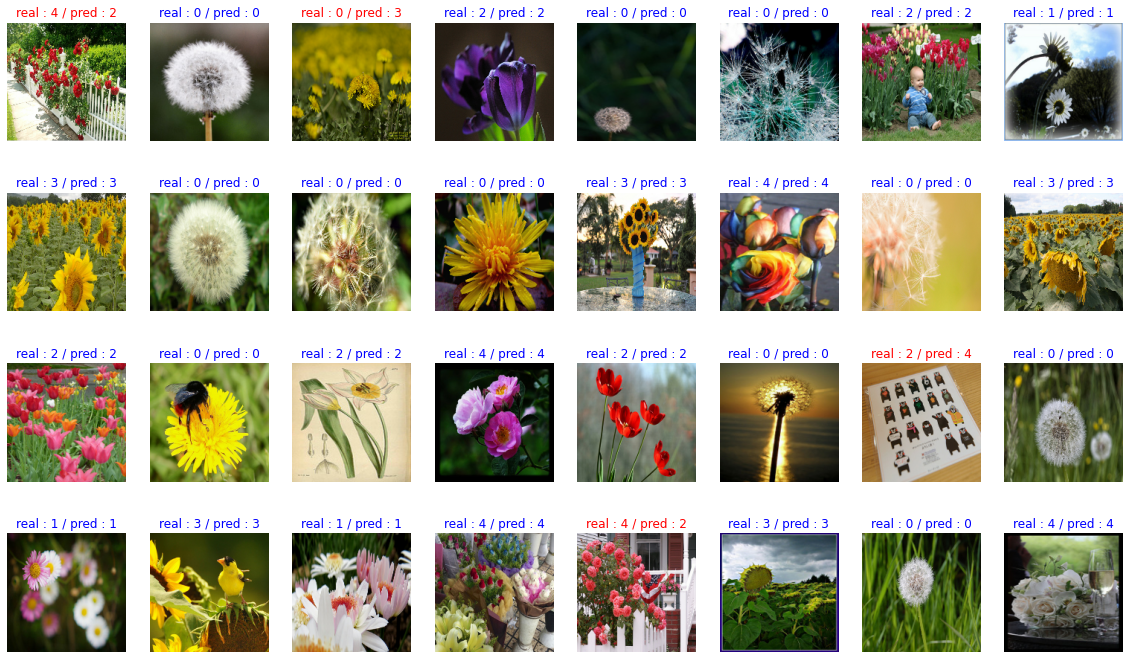

In [22]:
plt.figure(figsize=(20,12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4,8,idx+1)
    image=(image+1)/2
    plt.imshow(image)
    correct = label==prediction
    title = 'real : {} / pred : {}'.format(label, prediction)
    if not correct:
        plt.title(title, fontdict={'color':'red'})
    else:
        plt.title(title, fontdict={'color' : 'blue'})
    plt.axis('off')

#### Evaluate

In [23]:
test_loss, test_acc = model.evaluate(test_batches)

12/12 [==============================] - 1s 53ms/step - loss: 0.4836 - accuracy: 0.8719


In [24]:
print(test_acc)

0.8719345927238464


## Step 6. 모델 활용하기

#### Save model

In [26]:
checkpoint_dir = os.getenv("HOME") + "/aiffel/Project/EXPLORATION/E4/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')

In [27]:
model.save_weights(checkpoint_file_path)

if os.path.exists(checkpoint_file_path):
    print('checkpoint ok')

checkpoint ok


#### Show and predict

In [52]:
def show_and_predict(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath,filename)
    image=load_img(filepath, target_size=(img_size,img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1,img_size,img_size,3)
    prediction = model.predict(image)[0]
    idx = np.argmax(prediction)
    flowers = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
    print("This image seems {}% {}.".format(round(prediction[idx]*100),flowers[idx]))

In [53]:
img_dir_path = os.getenv("HOME") + "/aiffel/Project/EXPLORATION/E4/images"

In [54]:
filename = 'sunflower.jpeg'

This image seems 99.0% sunflowers.


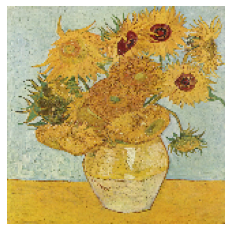

In [55]:
show_and_predict(img_dir_path, filename)

## Report

1.
처음에는 pre-trained model로 *VGG16*을 이용하여 학습하였습니다.  
pre-trained model = VGG16  
BATCH_SIZE = 32  
EPOCHS = 15  

<br>
**test accuracy가 83.92% 정도로 측정되었습니다.**

2.
pre-trained model로 *Xception*을 이용하여 학습해보았습니다.
pre-trained model = Xception
BATCH_SIZE = 32
EPOCHS = 15

**test accuracy가 87.1% 정도로 측정되었습니다.**

3.
pre-trained model로 *Xception*을 이용하고 dropout을 추가하여 학습해보았습니다.
pre-trained model = Xception
BATCH_SIZE = 32
EPOCHS = 10
DROPOUT = 0.4

**test accuracy가 85.5% 정도로 측정되었습니다.**

2번 모델을 이용하여, 고흐의 해바라기를 예측해보았습니다.